In [14]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import sys, subprocess, itertools

In [ ]:
import cv2
file_path = 'Data/20200212_150024.jpg'
img = cv2.imread(file_path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow(gray , cmap = 'gray')

In [2]:
import skimage
from skimage.measure import label, regionprops
from skimage.color import label2rgb
im = Image.open('Data/20200212_150024.jpg')
gray = skimage.color.rgb2gray(np.array(im))
imageTH = gray < .4
selem = skimage.morphology.disk(5)
openImage = skimage.morphology.opening(imageTH, selem)
imageTHCorr = np.logical_and( np.logical_not(openImage), imageTH)
label_image = label(imageTHCorr)

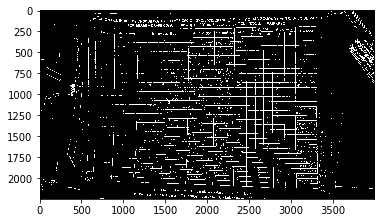

In [3]:
plt.imshow(imageTHCorr, cmap = 'gray')

In [4]:
lines = skimage.transform.probabilistic_hough_line(imageTHCorr, threshold=1, line_length=150,
                                 line_gap=5)

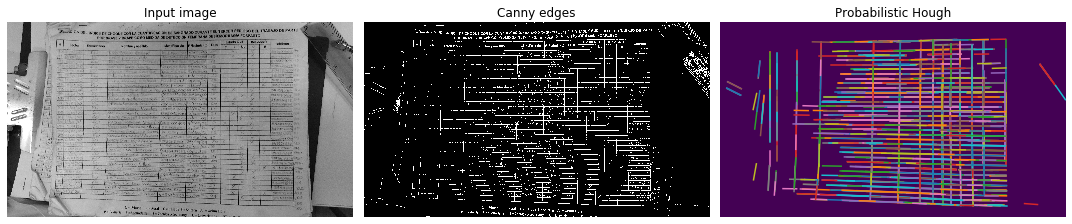

In [5]:
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(gray, cmap='gray')
ax[0].set_title('Input image')

ax[1].imshow(imageTHCorr, cmap='gray')
ax[1].set_title('Canny edges')

ax[2].imshow(imageTHCorr * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, imageTHCorr.shape[1]))
ax[2].set_ylim((imageTHCorr.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()

Text(0.5, 1.0, 'Probabilistic Hough')

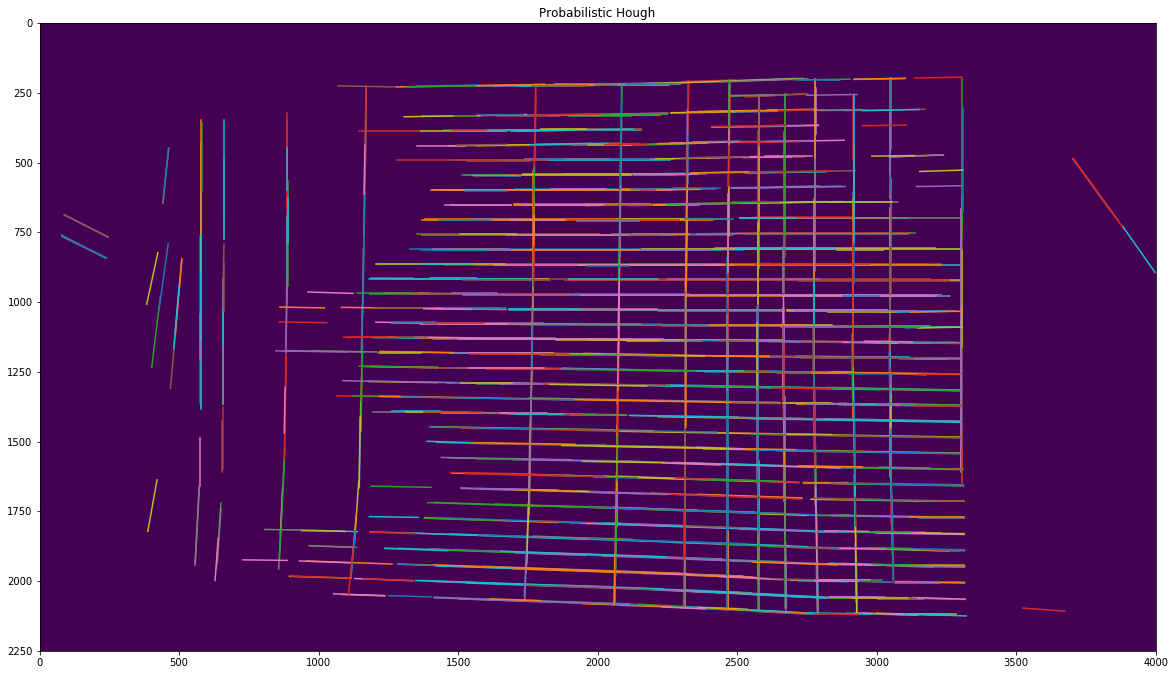

In [6]:
plt.figure(figsize = (20, 20))
plt.imshow(imageTHCorr * 0)
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.gca().set_xlim((0, imageTHCorr.shape[1]))
plt.gca().set_ylim((imageTHCorr.shape[0], 0))
plt.gca().set_title('Probabilistic Hough')


In [7]:
def distAngle(theta, theta_ref):
    v = [np.abs(theta - theta_ref), np.abs(- 2 *np.pi +  theta - theta_ref), np.abs(2 *np.pi +  theta - theta_ref)]
    return min(v)

In [47]:
import collections
collections.namedtuple('Line', 'p0 p1 b0 b1')

def _line2lineProjected(line1, line2, v):
    a, b, c, d = line1[0].dot(v), line1[1].dot(v), line2[0].dot(v), line2[1].dot(v)
    if a > b:
        a,b = b, a
    if c > d:
        c, d = d, c
    return max(max(a,c) -min(b,d), 0)

class OrientedLine:
    def __init__(self, p0, p1, b0, b1):
        self.p0 = p0
        self.p1 = p1
        self.b0 = b0
        self.b1 = b1
        if self.b1 < self.b0:
            self.b1, self.b0 = self.b0, self.b1
            self.p1, self.p0 = self.p0, self.p1
    def distance(self, l2, v):
        return (_line2lineProjected((self.p0, self.p1), (l2.p0, l2.p1), v))
    def orientedDistance(self, l2):
         return max(max(self.b0, l2.b0) -min(self.b1,l2.b1), 0)

In [48]:
#Assume they are relatively near 0 and pi/2m
rhos0 = []
rhospiHalfs = []
for l in lines:
    v = np.array(l[0]) - np.array(l[1])
    angle = np.angle(v[0] + 1j * v[1])
    if distAngle(angle, 0) < 0.1: 
        rhos0.append(angle if angle < np.pi else angle - 2 * np.pi)
    elif distAngle(angle, np.pi) < 0.1:
        rhos0.append(angle - np.pi)
        
    if distAngle(angle, np.pi/2) < 0.1: 
        rhospiHalfs.append(angle)
    elif distAngle(angle, np.pi *3/2) < 0.1:
        rhospiHalfs.append(angle - np.pi)
r0 = np.mean(rhos0)
v0 = np.array([np.cos(r0), np.sin(r0)])
rpiHalf = np.mean(rhospiHalfs)
vpiHalf = np.array([np.cos(rpiHalf), np.sin(rpiHalf)])


In [49]:
np.dot(v0, vpiHalf)
#TODO: projective transform, using a chessboard

0.00023055934364649665

Text(0.5, 1.0, 'Probabilistic Hough cropped')

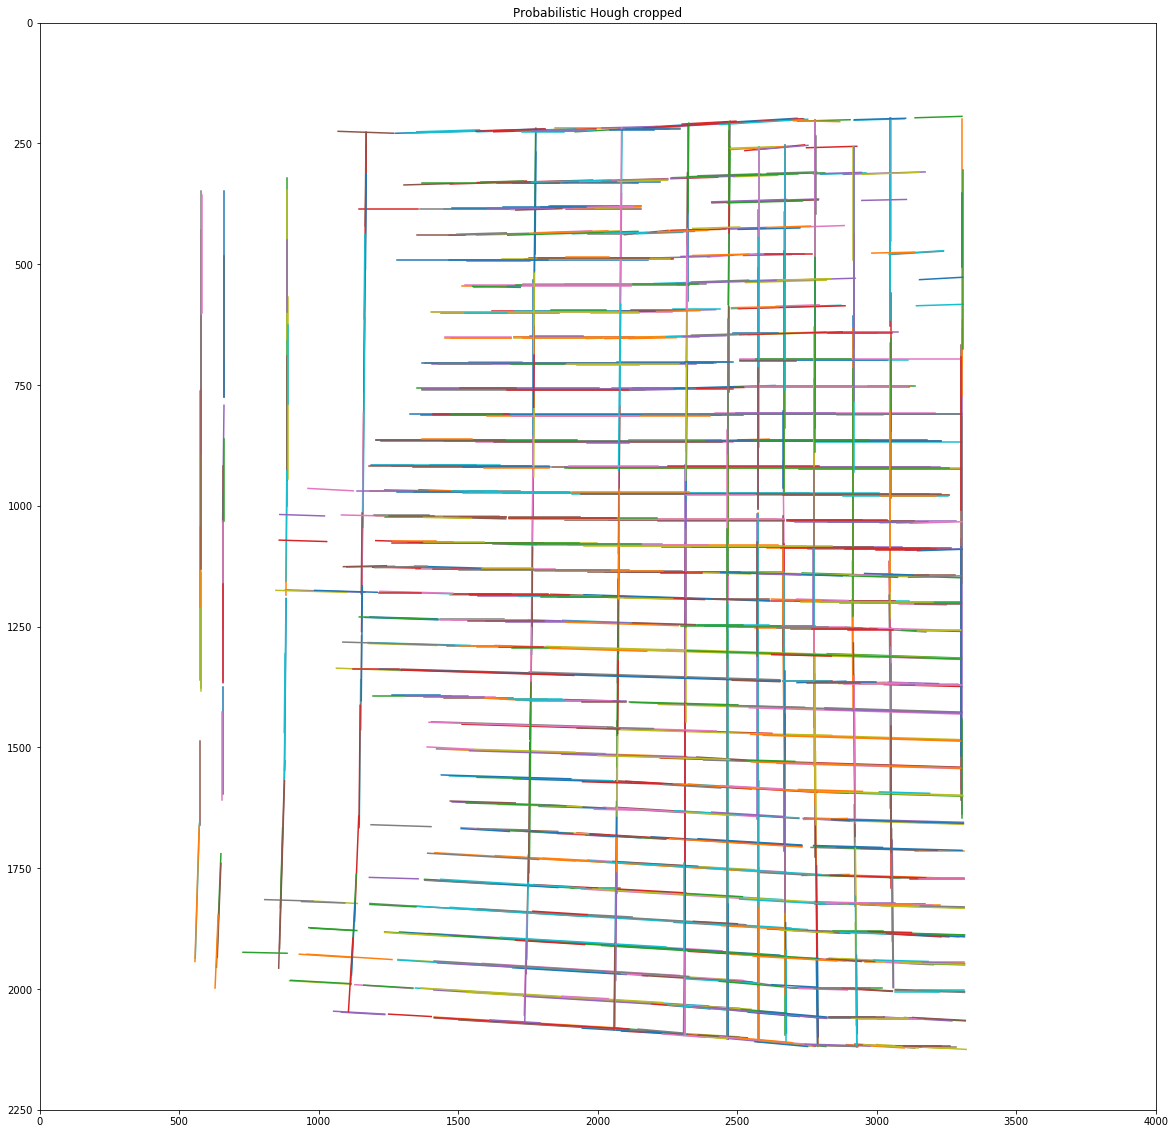

In [50]:
plt.figure(figsize = (20, 20))

#For each line, check if they are approximately r0 or piHalf
#Repetitive step, could reuse previous information
horizontalLines = []
verticalLines = []
for l in lines:
    p0, p1 = np.array(l[0]), np.array(l[1])
    v = (np.array(l[0]) - np.array(l[1])).astype(float)
    v /= np.linalg.norm(v)
    
    #manual crop
    if p0[0] < 500 or p0[0] > 3500:
        continue

    if np.abs(np.dot(v, v0)) > 1 -1e-2:
        b0, b1 = np.dot(vpiHalf, p0),  np.dot(vpiHalf, p1)
        horizontalLines.append(OrientedLine(p0, p1, b0, b1))
    elif np.abs(np.dot(v, vpiHalf)) > 1- 1e-2:
        b0, b1 = np.dot(v0, p0),  np.dot(v0, p1)
        verticalLines.append(OrientedLine(p0, p1, b0, b1))

    else:
        continue
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.gca().set_xlim((0, imageTHCorr.shape[1]))
plt.gca().set_ylim((imageTHCorr.shape[0], 0))
plt.gca().set_title('Probabilistic Hough cropped')


In [51]:
class Labels:
    def __init__(self, n):
        self.labels = {i : [i] for i in range(n)}
        self.labelIds = {i : i for i in range(n)}
    def mergeLabels(self, i, j):
        li_old = self.labelIds[i]
        lj = self.labelIds[j]
        if li_old == lj:
            return
        for k in self.labels[li_old]:
            self.labelIds[k] = self.labelIds[j]
        self.labels[lj] += self.labels[li_old]
        del self.labels[li_old]

In [67]:
#Join lines if b difference is small, and in axis is smaller than 300 pixels (to adjust)
horizontalLines = np.array(horizontalLines)
labelsHorizontal = Labels(len(horizontalLines))
#Force that any can have only one neighbour
for i,j in itertools.product(range(len(horizontalLines)), repeat = 2):
    if i <= j:
        continue
    if horizontalLines[i].orientedDistance(horizontalLines[j]) < 5 and  \
            horizontalLines[i].distance(horizontalLines[j], v0) < 100:
        labelsHorizontal.mergeLabels(i,j)


In [68]:
verticalLines = np.array(verticalLines)
labelsVertical = Labels(len(verticalLines))
#Force that any can have only one neighbour
for i,j in itertools.product(range(len(verticalLines)), repeat = 2):
    if i <= j:
        continue
    if verticalLines[i].orientedDistance(verticalLines[j]) < 5 and  \
            verticalLines[i].distance(verticalLines[j], v0) < 100:
        labelsVertical.mergeLabels(i,j)

In [69]:
def flatten2(v):
    vRes = np.zeros((len(v) * 2, 2))
    for i,vv in enumerate(v):
        vRes[2* i, :] = vv[0]
        vRes[2* i + 1, :] = vv[1]
    return vRes

(2250, 0)

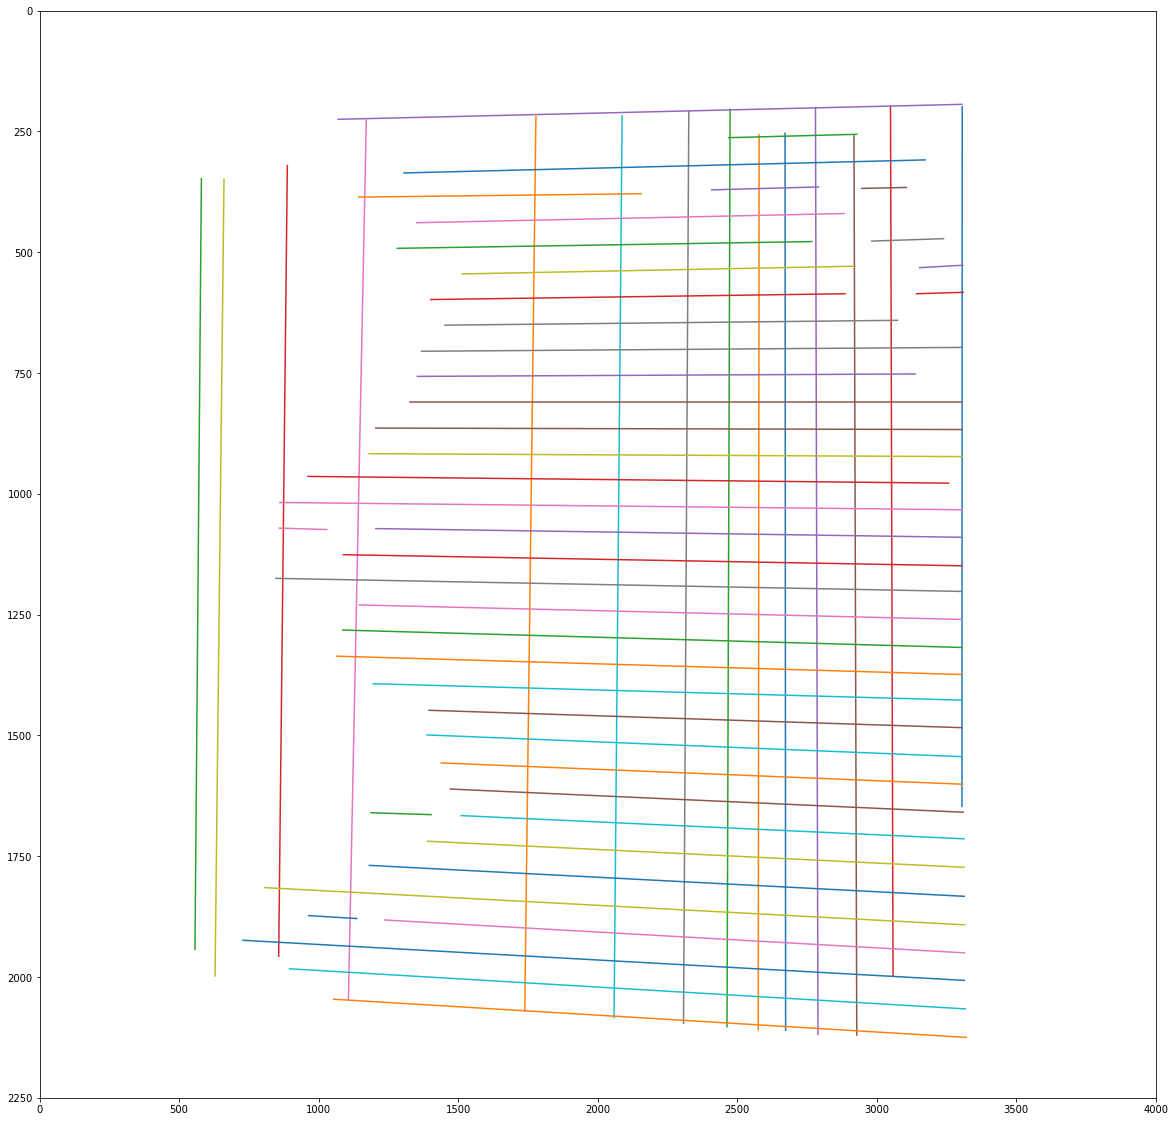

In [95]:
plt.figure(figsize = (20, 20))
linesHCleaned, linesVCleaned = [((0, 0), (0, 1)), ((4000, 0), (4000, 1))], [((0, 0), (1, 0)), ((0, 2250), (1, 2250))]
for l,v  in labelsVertical.labels.items():
    points = np.zeros([len(v) * 2, 2])
    for i, vv in enumerate(v):
        points[2 * i] = verticalLines[vv].p0
        points[2 * i + 1] = verticalLines[vv].p1
    pointsDotV = points.dot(vpiHalf)
    i,j = np.argmin(pointsDotV), np.argmax(pointsDotV) #Substitute by a curve fitting -> more stable
    plt.plot((points[i,0], points[j,0]), (points[i,1], points[j,1]), alpha = 1)
    linesVCleaned.append((points[i], points[j]))
    
for l,v  in labelsHorizontal.labels.items():
    points = np.zeros([len(v) * 2, 2])
    for i, vv in enumerate(v):
        points[2 * i] = horizontalLines[vv].p0
        points[2 * i + 1] = horizontalLines[vv].p1
    pointsDotV = points.dot(v0)
    i,j = np.argmin(pointsDotV), np.argmax(pointsDotV) #Substitute by a curve fitting -> more stable
    plt.plot((points[i,0], points[j,0]), (points[i,1], points[j,1]), alpha = 1)
    #plt.scatter(points[:,0], points[:,1])
    linesHCleaned.append((points[i], points[j]))

plt.gca().set_xlim((0, imageTHCorr.shape[1]))
plt.gca().set_ylim((imageTHCorr.shape[0], 0))


In [96]:
def line_intersection(line1, line2):
    """
    From SO
    """
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return (-10, -10)

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return (x, y)



In [120]:
linesHCleaned[0]

((0, 0), (0, 1))

In [100]:
def inROI(x, y, xMin, xMax, yMin, yMax):
    return xMin < x and x < xMax and yMin < y and y < yMax
inImage = lambda x, y: inROI(x, y, -1, 4001, -1, 2251)
intersections = collections.defaultdict(list)
#Extend all lines and detect intersection.
#The first two images
for i,j in itertools.product(range(len(linesHCleaned)), repeat = 2):
    if i < j:
        continue
    li, lj = linesHCleaned[i], linesHCleaned[j]
    p = line_intersection(li, lj)
    if inImage(*p):
        intersections[i].append(p)
        intersections[j].append(p)

In [111]:
intersections[0]

[(0.0, 239.8345259391771),
 (0.0, 811.0),
 (0.0, 1012.7199509403107),
 (0.0, 659.9580764488286),
 (0.0, 1679.9391575663026),
 (0.0, 1952.2947976878613),
 (0.0, 1733.5178236397749),
 (0.0, 393.9130434782609),
 (0.0, 300.66884531590415),
 (0.0, 958.1341463414634),
 (0.0, 1061.6812559467173),
 (0.0, 862.2793907663017),
 (0.0, 455.76762402088775),
 (0.0, 1165.6960943856793),
 (0.0, 913.6654117647059),
 (0.0, 1373.727962085308),
 (0.0, 1900.6020881670534),
 (0.0, 1317.958054439982),
 (0.0, 1264.3570784490532),
 (0.0, 609.3292929292929),
 (0.0, 760.7927170868347),
 (0.0, 1421.6879581151832),
 (0.0, 1841.5206929740134),
 (0.0, 710.6628748707342),
 (0.0, 1790.2236842105262),
 (0.0, 1466.394366197183),
 (0.0, 354.87687366167023),
 (0.0, 1523.0813704496788),
 (0.0, 504.07806191117095),
 (0.0, 1114.702300405954),
 (0.0, 408.7389033942559),
 (0.0, 1572.57911908646),
 (0.0, 1214.0685820203892),
 (0.0, 535.035019455253),
 (0.0, 562.2159090909091),
 (0.0, 1625.7513873473918),
 (0.0, 1839.337209302325

In [123]:
dist = lambda x, y: np.linalg.norm(np.array(x) - np.array(y))
newSegments = []
for i in range(2, len(linesHCleaned)):
    p0, p1 = linesHCleaned[i][0], linesHCleaned[i][1]
    d0, d1 = 1000000, 100000000
    i0, i1 = [], []
    for pj in intersections[i]:
        d00 = dist(pj, p0)
        d11 = dist(pj, p1)
        if d00 < d11:
            if d00 < d0:
                d0 = d00
                i0 = [(pj, p0)]
        else:
            if d11 < d1:
                d1 = d11
                i1 =[(pj, p1)]
    newSegments += i0 + i1

In [124]:
newSegments

[((0.0, 239.8345259391771), array([1070.,  225.])),
 ((4000.0, 184.3783542039356), array([3306.,  194.])),
 ((0.0, 811.0), array([1326.,  811.])),
 ((4000.0, 811.0), array([3305.,  811.])),
 ((0.0, 1012.7199509403107), array([ 861., 1018.])),
 ((4000.0, 1037.249795584628), array([3307., 1033.])),
 ((0.0, 659.9580764488286), array([1453.,  651.])),
 ((4000.0, 635.2971639950678), array([3075.,  641.])),
 ((0.0, 1679.9391575663026), array([1391., 1719.])),
 ((4000.0, 1792.2636505460218), array([3314., 1773.])),
 ((0.0, 1952.2947976878613), array([ 896., 1983.])),
 ((4000.0, 2089.371593724195), array([3318., 2066.])),
 ((0.0, 1733.5178236397749), array([1182., 1769.])),
 ((4000.0, 1853.5928705440901), array([3314., 1833.])),
 ((0.0, 393.9130434782609), array([1144.,  386.])),
 ((1956.7345132743362, 380.37831858407077), array([2156.,  379.])),
 ((0.0, 300.66884531590415), array([2470.,  263.])),
 ((4000.0, 239.66666666666666), array([2929.,  256.])),
 ((0.0, 958.1341463414634), array([962.,

(2250, 0)

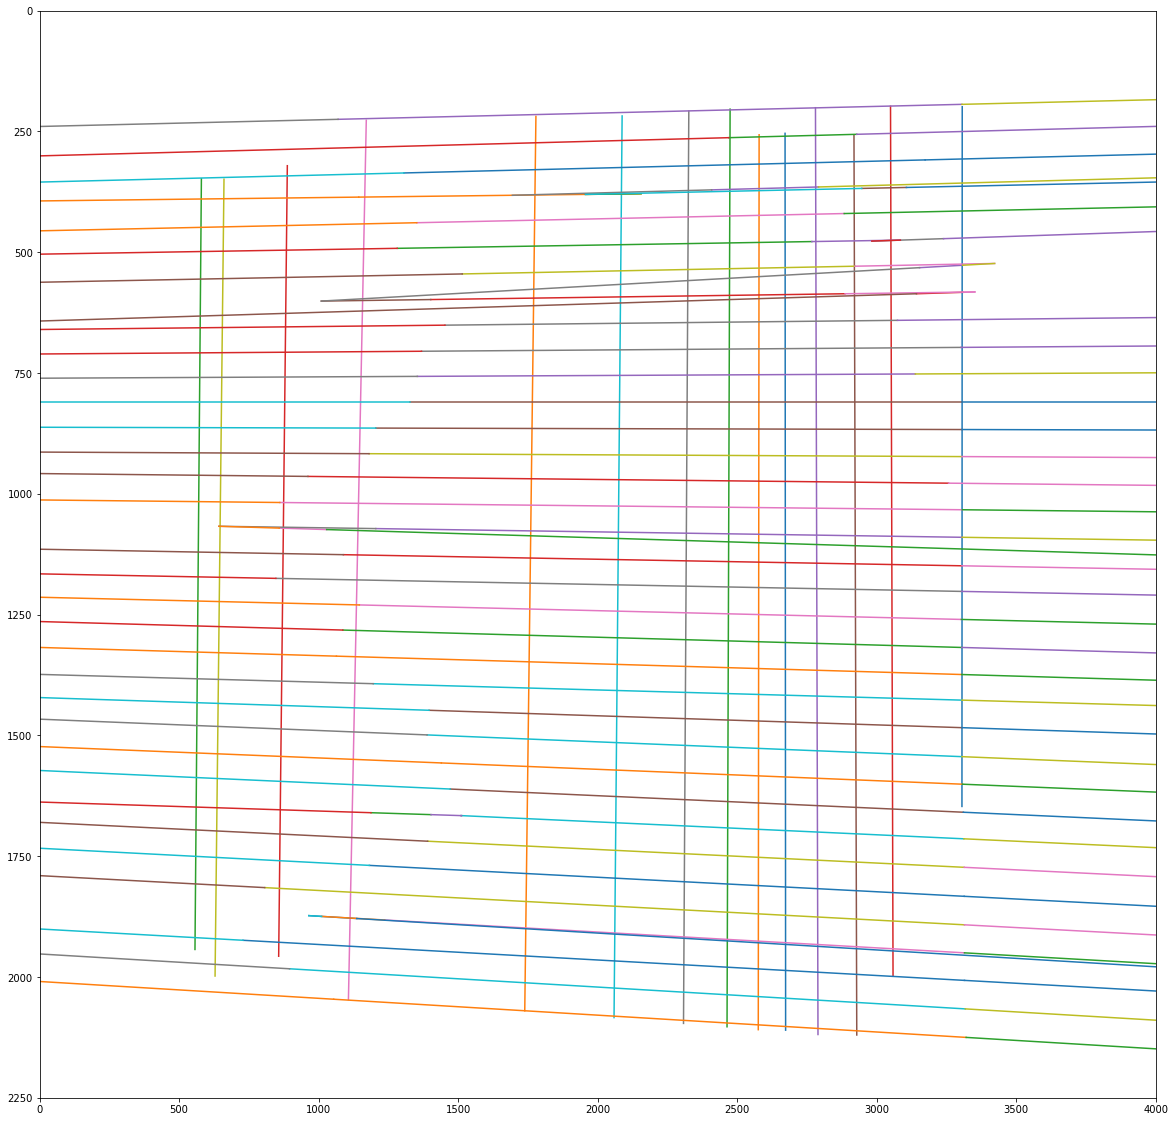

In [125]:
plt.figure(figsize = (20, 20))
linesHCleaned, linesVCleaned = [((0, 0), (0, 1)), ((4000, 0), (4000, 1))], [((0, 0), (1, 0)), ((0, 2250), (1, 2250))]
for l,v  in labelsVertical.labels.items():
    points = np.zeros([len(v) * 2, 2])
    for i, vv in enumerate(v):
        points[2 * i] = verticalLines[vv].p0
        points[2 * i + 1] = verticalLines[vv].p1
    pointsDotV = points.dot(vpiHalf)
    i,j = np.argmin(pointsDotV), np.argmax(pointsDotV) #Substitute by a curve fitting -> more stable
    plt.plot((points[i,0], points[j,0]), (points[i,1], points[j,1]), alpha = 1)
    linesVCleaned.append((points[i], points[j]))
    
for l,v  in labelsHorizontal.labels.items():
    points = np.zeros([len(v) * 2, 2])
    for i, vv in enumerate(v):
        points[2 * i] = horizontalLines[vv].p0
        points[2 * i + 1] = horizontalLines[vv].p1
    pointsDotV = points.dot(v0)
    i,j = np.argmin(pointsDotV), np.argmax(pointsDotV) #Substitute by a curve fitting -> more stable
    plt.plot((points[i,0], points[j,0]), (points[i,1], points[j,1]), alpha = 1)
    #plt.scatter(points[:,0], points[:,1])
    linesHCleaned.append((points[i], points[j]))

for p0, p1 in newSegments:
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

plt.gca().set_xlim((0, imageTHCorr.shape[1]))
plt.gca().set_ylim((imageTHCorr.shape[0], 0))
